### 模型 
wx+b=0

### 损失函数

误分类点到超平面的距离

$L(w, b) = -\Sigma{y_{i}(w*x_{i} + b)}$

l>=0：更新

当l<0,不更新

### 算法
随机梯度下降



In [337]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
import torch
from torch import nn

## 数据准备



In [338]:
import datetime

#打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)


In [339]:
# 正实例点 +1， 负实例点 -1
x = torch.tensor([[3.0,3],
                 [4,3],
                 [1,1]])
y = torch.tensor([1,1,-1])
x, x.dim(), y, y.dim()

(tensor([[3., 3.],
         [4., 3.],
         [1., 1.]]),
 2,
 tensor([ 1,  1, -1]),
 1)

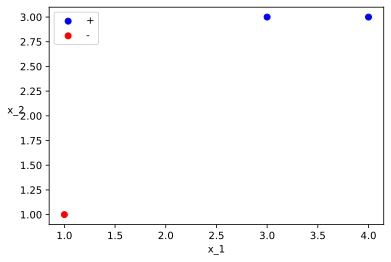

In [340]:
# 数据可视化
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# plt.figure(figsize = (12,5))
plt.scatter(x[:2,0].numpy(),x[:2,1].numpy(), c = "b",label = "+")
plt.scatter(x[2,0].numpy(),x[2,1].numpy(), c = "r",label = "-")

plt.legend()
plt.xlabel("x_1")
plt.ylabel("x_2",rotation = 360)
plt.show()

In [341]:
# 构建数据管道迭代器
batch_size = 1
def data_iter(features, labels, batch_size=batch_size):
    num_examples = len(features)
    indices = list(range(num_examples))
#     np.random.shuffle(indices)  #样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        indexs = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])
        yield  features.index_select(0, indexs), labels.index_select(0, indexs)

# (features,labels) = next(data_iter(x,y,batch_size))
# print(features, labels)

for i,v in data_iter(x,y,batch_size):
    print(i,v)

tensor([[3., 3.]]) tensor([1])
tensor([[4., 3.]]) tensor([1])
tensor([[1., 1.]]) tensor([-1])


In [342]:
# 定义感知机模型
w0 = torch.tensor([[2.0],[-3.0]])
b0 = torch.tensor([[10.0]])
class Perceptron: 
    def __init__(self):
        self.w = torch.zeros_like(w0,requires_grad=True)
        self.b = torch.zeros_like(b0,requires_grad=True)

    #正向传播
    def forward(self,x):
        return x@self.w + self.b
    
    def _sign(self, value):
        # 分类预测函数
        if value< 0:
            return -1
        return 1

    # 损失函数
    def loss_func(self,y_pred,y_true):  
        return -y_true * y_pred

model = Perceptron()

In [343]:
# 训练模型

def train_step(model, features, labels):

    predictions = model.forward(features)
    loss = model.loss_func(predictions,labels)
    print(f'loss：{loss}')
    if loss>=0:
        print('更新梯度')
        print(f'更新前 w：{model.w}')
        print(f'更新前 b：{model.b}')
    
        # 反向传播求梯度
        loss.backward()

        # 使用torch.no_grad()避免梯度记录，也可以通过操作 model.w.data 实现避免梯度记录 
        with torch.no_grad():
            # 梯度下降法更新参数
            model.w -= 1*model.w.grad
            model.b -= 1*model.b.grad

            # 梯度清零
            model.w.grad.zero_()
            model.b.grad.zero_()
    return loss

In [344]:
# 测试train_step效果
batch_size = 1
next(data_iter(x,y,batch_size))


(tensor([[3., 3.]]), tensor([1]))

In [345]:

def train_model(model,epochs):
    for epoch in range(1,epochs+1):
        for features, labels in data_iter(x,y,batch_size):
            loss = train_step(model,features,labels)
#         if epoch%1==0:
            print("epoch =",epoch,"loss = ",loss.item())
            print("model.w =",model.w.data)
            print("model.b =",model.b.data)
            printbar()
train_model(model,epochs = 10)

loss：tensor([[-0.]], grad_fn=<MulBackward0>)
更新梯度
更新前 w：tensor([[0.],
        [0.]], requires_grad=True)
更新前 b：tensor([[0.]], requires_grad=True)
epoch = 1 loss =  -0.0
model.w = tensor([[3.],
        [3.]])
model.b = tensor([[1.]])

================================================================================2022-04-24 22:56:18
loss：tensor([[-22.]], grad_fn=<MulBackward0>)
epoch = 1 loss =  -22.0
model.w = tensor([[3.],
        [3.]])
model.b = tensor([[1.]])

================================================================================2022-04-24 22:56:18
loss：tensor([[7.]], grad_fn=<MulBackward0>)
更新梯度
更新前 w：tensor([[3.],
        [3.]], requires_grad=True)
更新前 b：tensor([[1.]], requires_grad=True)
epoch = 1 loss =  7.0
model.w = tensor([[2.],
        [2.]])
model.b = tensor([[0.]])

================================================================================2022-04-24 22:56:18
loss：tensor([[-12.]], grad_fn=<MulBackward0>)
epoch = 2 loss =  -12.0
model.w = tensor([[2.],
     

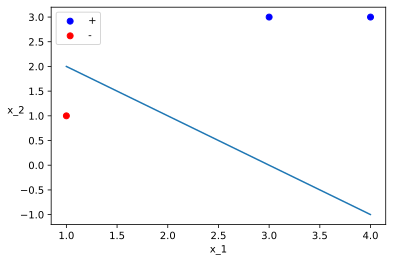

In [346]:
# 结果可视化, 绘制学习完的 wx+b=0 曲线
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# plt.figure(figsize = (12,5))
plt.scatter(x[:2,0].numpy(),x[:2,1].numpy(), c = "b",label = "+")
plt.scatter(x[2,0].numpy(),x[2,1].numpy(), c = "r",label = "-")
plt.plot(x[:,0], (-x[:,0]*model.w.detach().numpy()[0]-model.b.detach().numpy()[0])/model.w.detach().numpy()[1])

plt.legend()
plt.xlabel("x_1")
plt.ylabel("x_2",rotation = 360)
plt.show()




## API 调用

In [333]:
from torch import nn
import torch.nn.functional as F
    
class ToyModel(nn.Module):
    def __init__(self):
        super(ToyModel, self).__init__()
        self.fc1 = nn.Linear(2,1)
        self._init_parameters()

    # 正向传播
    def forward(self,x):
        y = self.fc1(x)
        return y

    # 损失函数
    def loss_func(self,y_pred,y_true):
        return -y_true * y_pred

    # 优化器
    @property
    def optimizer(self):
        return torch.optim.SGD(self.parameters(),lr = 1)
    
    def _init_parameters(self):
        # 自定义参数初始化
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.zeros_(m.weight.data)
                nn.init.constant_(m.bias.data, 0)

model = ToyModel()


for name, p in model.named_parameters():
    print(name)
    print(p)

fc1.weight
Parameter containing:
tensor([[0., 0.]], requires_grad=True)
fc1.bias
Parameter containing:
tensor([0.], requires_grad=True)


In [334]:
# 测试模型结构
batch_size = 1

(features,labels) = next(data_iter(x,y,batch_size))
print(features,labels)
predictions = model(features)

loss = model.loss_func(predictions,labels)

print("init loss:",loss)

tensor([[3., 3.]]) tensor([1])
init loss: tensor([[-0.]], grad_fn=<MulBackward0>)


In [335]:
def train_step(model, features, labels):

    # 正向传播求损失
    predictions = model(features)
    loss = model.loss_func(predictions,labels)
    if loss >=0:
        print(f'更新参数..')
        # 反向传播求梯度
        loss.backward()

        # 更新模型参数
        model.optimizer.step()
        model.optimizer.zero_grad()

    return loss.item()

# # 测试train_step效果
# (features,labels) = next(data_iter(x,y,batch_size))
# train_step(model,features,labels)

In [336]:

def train_model(model,epochs):
    for epoch in range(1,epochs+1):
        for features, labels in data_iter(x,y,batch_size):
            loss = train_step(model,features,labels)
#         if epoch%1==0:
            print("epoch =",epoch,"loss = ",loss)
            for parameters in model.parameters():
                print(parameters)
#             print("model.w =",model.weight)
#             print("model.b =",model.bias)
            printbar()
train_model(model,epochs = 10)

更新参数..
epoch = 1 loss =  -0.0
Parameter containing:
tensor([[3., 3.]], requires_grad=True)
Parameter containing:
tensor([1.], requires_grad=True)

================================================================================2022-04-24 22:53:01
epoch = 1 loss =  -22.0
Parameter containing:
tensor([[3., 3.]], requires_grad=True)
Parameter containing:
tensor([1.], requires_grad=True)

================================================================================2022-04-24 22:53:01
更新参数..
epoch = 1 loss =  7.0
Parameter containing:
tensor([[2., 2.]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)

================================================================================2022-04-24 22:53:01
epoch = 2 loss =  -12.0
Parameter containing:
tensor([[2., 2.]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)

================================================================================2022-04-24 22:53:01
epoch = 2 loss =  -14.0
P